In [1]:
import scanpy
import pandas as pd
import magic, scprep
import numpy as np
import matplotlib.pyplot as plt

# Map Ctrl cell to WT cells

In [2]:
# Get our beta cell dataset and STZ dataset (only Ctrl cells for mapping to WT)

adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')
stz = scanpy.read_h5ad('data/stz_beta_ins1_ins2.h5ad')
stz_ctrl = stz[stz.obs.treatment == 'Ctrl']

In [3]:
# Get WT PC operator and WT PCs

wt_pc_op = pd.read_pickle('../analysis_archetypes/results/WT_magic_pc_op.pkl')
wt_magic_pc_norm = pd.read_pickle('../analysis_archetypes/results/WT_magic_pc_norm.pkl')

In [25]:
path = 'results/output_stz_to_wt_cycle_1_correspondence_lambda_10_corr_correspondence_training_counter_15000.npz'

In [26]:
# Get scMMGAN mapped data and map to WT PCs

out = np.load(path)
ctrl_magan = pd.DataFrame(out['stz_to_wt'], index=stz_ctrl.obs_names, columns=adata_beta.var_names)
ctrl_magan_magic_pc = wt_pc_op.transform(ctrl_magan)
ctrl_magan_magic_pc_norm = ctrl_magan_magic_pc / np.std(ctrl_magan_magic_pc[:, 0])

In [27]:
cmap = {'Ins_1': 'salmon', 'Vehicle-STZ': 'darkseagreen', 'β1': 'lightblue', 'β2': 'cornflowerblue', 'β-mSTZ': 'midnightblue','Ctrl': 'darkmagenta', 'Vehicle-STZ': 'darkseagreen'}

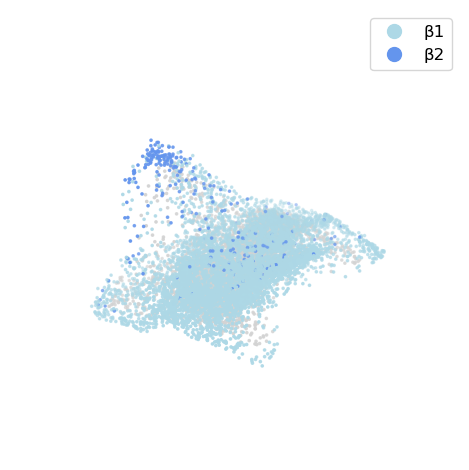

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.axis('off')
plt.tight_layout()
scprep.plot.scatter3d(wt_magic_pc_norm, azim=-150, ax=ax, c='lightgray', ticks=None)
scprep.plot.scatter3d(ctrl_magan_magic_pc_norm, azim=-150, ax=ax, c=stz_ctrl.obs.groups_named_fine, cmap=cmap, 
                      mask=~stz_ctrl.obs.groups_named_fine.isin(['β-mSTZ']))
fig.savefig('figures/mapping_ctrl_to_wt.png', dpi=300)

## AAnet

In [6]:
import sklearn, torch, sys
sys.path.append('~/bin/AAnet/') # location of AAnet
from AAnet_torch import *

In [7]:
N_ARCHETYPES = 7

In [9]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=wt_magic_pc_norm.shape[1],
                             device=device)

In [10]:
data_loader = torch.utils.data.DataLoader(ctrl_magan_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

In [12]:
model.load_state_dict(torch.load('../analysis_archetypes/results/WT_7_model_state_dict'))

<All keys matched successfully>

In [13]:
archetypal_embedding = model.encode(torch.Tensor(ctrl_magan_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

In [21]:
at_dist = []
for row in barycentric_archetypal_embedding:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('WT AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
ctrl_at_comms = pd.Series(at_dist, index = stz_ctrl.obs_names)

In [29]:
ctrl_at_comms.to_csv('results/ctrl_at_comms.csv')

## Run 2 

In [33]:
adata_beta_wt = adata_beta[adata_beta.obs['samples'] == 'WT']
path = 'results/output_run_2_stz_to_wt_cycle_1_correspondence_lambda_10_mse_correspondence.npz'
adata_beta_wt = adata_beta_wt[:, adata_beta[:, ~adata_beta.var['names'].duplicated()].var.index]

In [34]:
from sklearn import decomposition

In [35]:
data_magic_op = magic.MAGIC(random_state=42, t=10, verbose=False)
data_magic = data_magic_op.fit_transform(adata_beta_wt.to_df())

data_pc_op = decomposition.PCA(n_components=20, random_state=42)
data_magic_pc = data_pc_op.fit_transform(data_magic)
data_magic_pc_norm = data_magic_pc / np.std(data_magic_pc[:, 0])

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 16479-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [38]:
# Get scMMGAN mapped data and map to WT PCs

out = np.load(path)
ctrl_magan = pd.DataFrame(out['stz_to_wt'], index=stz_ctrl.obs_names, columns=adata_beta_wt.var_names)
ctrl_magan_magic_pc = data_pc_op.transform(ctrl_magan)
ctrl_magan_magic_pc_norm = ctrl_magan_magic_pc / np.std(ctrl_magan_magic_pc[:, 0])

<Axes3D: xlabel='PC1', ylabel='PC2', zlabel='PC3'>

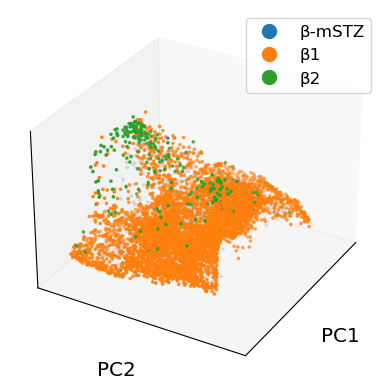

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(wt_magic_pc_norm, azim=-150, ax=ax, c='lightgray', ticks=None)
scprep.plot.scatter3d(ctrl_magan_magic_pc_norm, azim=-150, ax=ax, c=stz_ctrl.obs.groups_named_fine)

In [41]:
N_ARCHETYPES = 7

In [44]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=data_magic_pc_norm.shape[1],
                             device=device)

In [45]:
data_loader = torch.utils.data.DataLoader(ctrl_magan_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

In [46]:
model.load_state_dict(torch.load('../analysis_archetypes/results/WT_7_model_state_dict'))

<All keys matched successfully>

In [47]:
archetypal_embedding = model.encode(torch.Tensor(ctrl_magan_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

In [48]:
at_dist = []
for row in barycentric_archetypal_embedding:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('WT AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
ctrl_at_comms = pd.Series(at_dist, index = stz_ctrl.obs_names)

In [49]:
ctrl_at_comms.to_csv('results/ctrl_at_comms_run_2.csv')